In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from math import pi

import cmath

from qutip import *
import qutip.logging_utils as logging
logger = logging.get_logger()

import qutip.control.dynamics as dynamics
import qutip.control.errors as errors
import qutip.control.pulsegen as pulsegen

In [64]:
wr = 5.0622 * 2 * pi        # resonator frequency
wq = 4.7206 * 2 * pi        # qubit frequency
chi = 0.0052 * 2 * pi       # parameter in the dispersive hamiltonian

delta = abs(wr - wq)        # detuning
g = np.sqrt(delta * chi)    # coupling strength that is consistent with chi

N = 2
use_rwa = True
n_th_a = 0.0

tlist = np.linspace(0,100,1001)
t1 = 800

In [65]:
# initial state
psi0 = tensor(basis(N,0), basis(2,1))  # start with an excited atom

# cavity destruction operator
a = tensor(destroy(N), qeye(2))

# operator for qubit
sm = tensor(qeye(N), destroy(2))

nr = a.dag() * a
nq = sm.dag() * sm

# decoupled hamiltonian
H0 = wr * a.dag() * a + wq * sm.dag() * sm

# interaction hamiltonian
if use_rwa:
    H1 = (a.dag() * sm + a * sm.dag())
else:
    H1 = (a.dag() + a) * (sm + sm.dag())
    
H = H0 + g * H1

In [66]:
# collapse operators that describe dissipation

c_ops = []
    
# qubit relaxation
rate = 1/t1
# c_ops.append(np.sqrt(rate) * sm)
c_ops.append(np.sqrt(rate * (1+n_th_a)) * sm)
c_ops.append(np.sqrt(rate * n_th_a) * sm.dag())
# c_ops.append(np.sqrt(t2) * sz)

In [67]:
def H1_coeff(t,args):
    W_p = args['Omega1']
    nu = args['nu'] 
    z = complex(0,-t*nu + pi/2)
    return wq - W_p*(cmath.exp(z))

def H2_coeff(t, args):
    W_p = args['Omega2']
    nu = args['nu']
    z = complex(0,t*nu + pi/2)
    return wq - W_p*(cmath.exp(z))

def wr_t(t,args=None):
    return wr

def wq_t(t,args=None):
    return wq

def plotFrequencies(ax, times, wr_t, Colour, labels_, linestyle_):
    """
    Function plots the frequencies as a function of times
    """
    ax.plot(times, np.array(list(map(wr_t, times)))/(2*pi), Colour, linewidth=2, label=labels_, linestyle=linestyle_)
    
    #ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
    return 

def setLabels(ax, tr, th, plot_no):
    """
    Function sets the labels of the x-y axis in the plot below
    """
    if plot_no == 0:
        ax.set_ylabel("Frequency (GHz)", fontsize=16)
        ax.set_title(labelTimes(tr, th))
    else:
        ax.set_xlabel("Time (ns)")
        ax.set_ylabel("Occupation \n probability")
    return 

def plotProb(ax, times, component, res, Colour, labels_, linestyle_):
    """
    Function plots the occupation probabilities of the components after running mesolve
    """
    ax.plot(times, np.real(expect(component, res.states)), Colour, linewidth=1.5, label=labels_, linestyle=linestyle_)
    
    ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
    return 

def setXYlabel(ax, x, y, req_title, title_):
    """
    Generic function to set labels for plots
    """
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    if req_title == True:
        ax.set_title(title_)
    return 

def plotSineWaves(ax, H1_coeff, H2_coeff, times):    
    ax.plot(times, [H1_coeff(t, args=args)/(2*pi)for t in times], 'r', linewidth=2, label=r"$- \Omega_pe^{-i\nu t}$" )
    ax.plot(times, [H2_coeff(t, args=args)/(2*pi) for t in times], 'b:', linewidth=2, label=r"$- \Omega_pe^{+i\nu t}$")
    ax.plot(times, [(H1_coeff(t, args=args)+H2_coeff(t, args=args) -wq)/(2*pi) for t in times], 'g', label=r"$- \Omega_pe^{-i\nu t}- \Omega_pe^{+i\nu t}$")
    ax.legend(loc="upper right")
    setXYlabel(ax, 'Time (ns)', 'Frequency (GHz)', True, r'Perturbating Qubit 1: $- f_1(t)H_1 - f_2(t)H_2$ ')
    return

In [68]:
# time dependent Hamiltonian
args = {'Omega1': 0.75*(wr-wq), 'nu': 0.2, 'Omega2': 0.75*(wr-wq)}
H_t = [H, [sm.dag(), H1_coeff], [sm, H2_coeff]]

# Evolving the system
output = mesolve(H_t, psi0, tlist, c_ops, [], args=args)

C:\Users\stpau\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\stpau\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\stpau\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


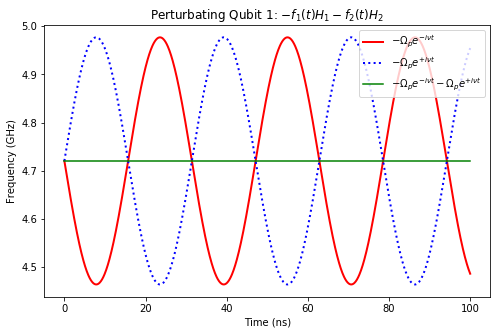

In [69]:
fig, ax = plt.subplots(figsize=(8,5))
plotSineWaves(ax, H1_coeff, H2_coeff, tlist)

C:\Users\stpau\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\stpau\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


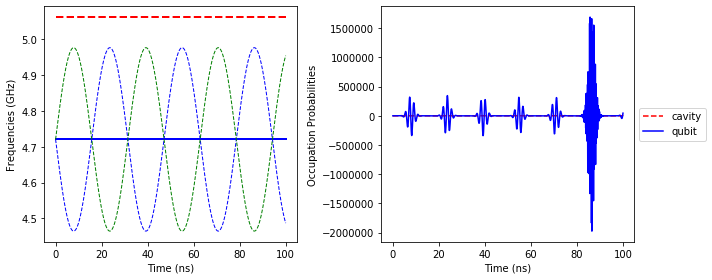

In [70]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))

labels_ = ["cavity", "qubit"]
w_list = [wr_t, wq_t]
colors_ = ['r', 'b']
linestyle_ = ['--', '-']
components_ = [nr,nq]

for i in [0, 1]:
    plotFrequencies(axes[0], tlist, w_list[i], colors_[i], labels_[i], linestyle_[i])
axes[0].plot(tlist, [H1_coeff(t, args=args)/(2*pi)for t in tlist], 'b--', linewidth=1., label=r"$- \Omega_pe^{-i\nu t}$" )
axes[0].plot(tlist, [H2_coeff(t, args=args)/(2*pi) for t in tlist], 'g--', linewidth=1., label=r"$- \Omega_pe^{+i\nu t}$")    
setXYlabel(axes[0], 'Time (ns)', 'Frequencies (GHz)', False, ' ')

for i in [0, 1]:
    plotProb(axes[1], tlist, components_[i], output, colors_[i], labels_[i], linestyle_[i])
setXYlabel(axes[1], 'Time (ns)', 'Occupation Probabilities', False, ' ')

fig.tight_layout()